Example Source: https://www.kaggle.com/codoes/customer-personality-analysis

Customer Personality Analysis is a detailed analysis of a company’s ideal customers. It helps a business to better understand its customers and makes it easier for them to modify products according to the specific needs, behaviors and concerns of different types of customers.

Customer personality analysis helps a business to modify its product based on its target customers from different types of customer segments. For example, instead of spending money to market a new product to every customer in the company’s database, a company can analyze which customer segment is most likely to buy the product and then market the product only on that particular segment.

In [56]:
# Import libraries
import numpy as np
import pandas as pd
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt, numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap
from sklearn import metrics
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
np.random.seed(42)

In [57]:
#Loading the dataset
data = pd.read_csv("marketing_campaign.csv", sep="\t")
print("Number of datapoints:", len(data))

Number of datapoints: 2240


### DATA CLEANING

In [58]:
#Information on Features
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [30]:
# To remove the NA values
data = data.dropna()
print("The total number of data-points after removing the rows with missing values are:", len(data))

The total number of data-points after removing the rows with missing values are: 2216


### Creating Some New Features

The original datasets have some columns that are similar (combined into one feature) or don't make sense (dropped) with the customer segment analysis. In order to let the input features better represent the customer info/behaviors, we do the following processes.

In [59]:
data["Dt_Customer"] = pd.to_datetime(data["Dt_Customer"])
dates = []
for i in data["Dt_Customer"]:
    i = i.date()
    dates.append(i)  
# Dates of the newest and oldest recorded customer
print("The newest customer's enrolment date in the records:",max(dates))
print("The oldest customer's enrolment date in the records:",min(dates))

The newest customer's enrolment date in the records: 2014-12-06
The oldest customer's enrolment date in the records: 2012-01-08


In [60]:
#Created a feature "Customer_For", which represent the days that customers join the merchandise center
days = []
d1 = max(dates) #taking it to be the newest customer
for i in dates:
    delta = d1 - i
    days.append(delta)
data["Customer_For"] = days
data["Customer_For"] = data["Customer_For"].dt.days

In [61]:
print("Total categories in the feature Marital_Status:\n", data["Marital_Status"].value_counts(), "\n")
print("Total categories in the feature Education:\n", data["Education"].value_counts())

Total categories in the feature Marital_Status:
 Married     864
Together    580
Single      480
Divorced    232
Widow        77
Alone         3
Absurd        2
YOLO          2
Name: Marital_Status, dtype: int64 

Total categories in the feature Education:
 Graduation    1127
PhD            486
Master         370
2n Cycle       203
Basic           54
Name: Education, dtype: int64


In [62]:
#Feature Engineering
#Age of customer today
data["current_year"] = 2022
data["Age"] = data["current_year"]-data["Year_Birth"]

#Total spendings on various items
data["Spent"] = data["MntWines"]+ data["MntFruits"]+ data["MntMeatProducts"]+ data["MntFishProducts"]+ data["MntSweetProducts"]+ data["MntGoldProds"]

#Deriving living situation by marital status"Alone"
data["Living_With"]=data["Marital_Status"].replace({"Married":"Partner", "Together":"Partner", "Absurd":"Alone", "Widow":"Alone", "YOLO":"Alone", "Divorced":"Alone", "Single":"Alone",})

#Feature indicating total children living in the household
data["Children"]=data["Kidhome"]+data["Teenhome"]

#Feature for total members in the household
data["Family_Size"] = data["Living_With"].replace({"Alone": 1, "Partner":2})+ data["Children"]

#Feature pertaining parenthood
data["Is_Parent"] = np.where(data.Children> 0, 1, 0)

#Segmenting education levels in three groups
data["Education"]=data["Education"].replace({"Basic":"Undergraduate","2n Cycle":"Undergraduate", "Graduation":"Graduate", "Master":"Postgraduate", "PhD":"Postgraduate"})

#For clarity
data=data.rename(columns={"MntWines": "Wines","MntFruits":"Fruits","MntMeatProducts":"Meat","MntFishProducts":"Fish","MntSweetProducts":"Sweets","MntGoldProds":"Gold"})

#Dropping some of the redundant features
to_drop = ["Marital_Status", "Dt_Customer", "Z_CostContact", "Z_Revenue", "Year_Birth", "ID", "current_year"]
data = data.drop(to_drop, axis=1)

In [92]:
data.describe()

,Education,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,...,Customer_For,Age,Spent,Living_With,Children,Family_Size,Is_Parent,Clusters_kmean,Clusters,Total_Promos
count,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000,...,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000
mean,0.609855,51958.810579,0.441682,0.505877,49.019439,305.287523,26.329566,167.029837,37.648734,27.046564,...,512.144213,53.086347,607.268083,0.645570,0.947559,2.593128,0.714286,1.508137,1.381555,0.298373
std,0.682635,21527.278844,0.536955,0.544253,28.943121,337.322940,39.744052,224.254493,54.772033,41.090991,...,232.551465,11.701599,602.513364,0.478449,0.749466,0.906236,0.451856,1.076633,1.106693,0.679570
min,0.000000,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,26.000000,5.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,35233.500000,0.000000,0.000000,24.000000,24.000000,2.000000,16.000000,3.000000,1.000000,...,340.000000,45.000000,69.000000,0.000000,0.000000,2.000000,0.000000,1.000000,0.000000,0.000000
50%,0.000000,51371.000000,0.000000,0.000000,49.000000,175.500000,8.000000,68.000000,12.000000,8.000000,...,513.000000,52.000000,397.000000,1.000000,1.000000,3.000000,1.000000,2.000000,1.000000,0.000000
75%,1.000000,68487.000000,1.000000,1.000000,74.000000,505.000000,33.000000,232.250000,50.000000,33.000000,...,686.000000,63.000000,1048.000000,1.000000,1.000000,3.000000,1.000000,2.000000,2.000000,0.000000
max,2.000000,162397.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,262.000000,...,1063.000000,82.000000,2525.000000,1.000000,3.000000,5.000000,1.000000,3.000000,3.000000,4.000000


Reletive Plot Of Some Selected Features: A Data Subset


<Figure size 576x396 with 0 Axes>

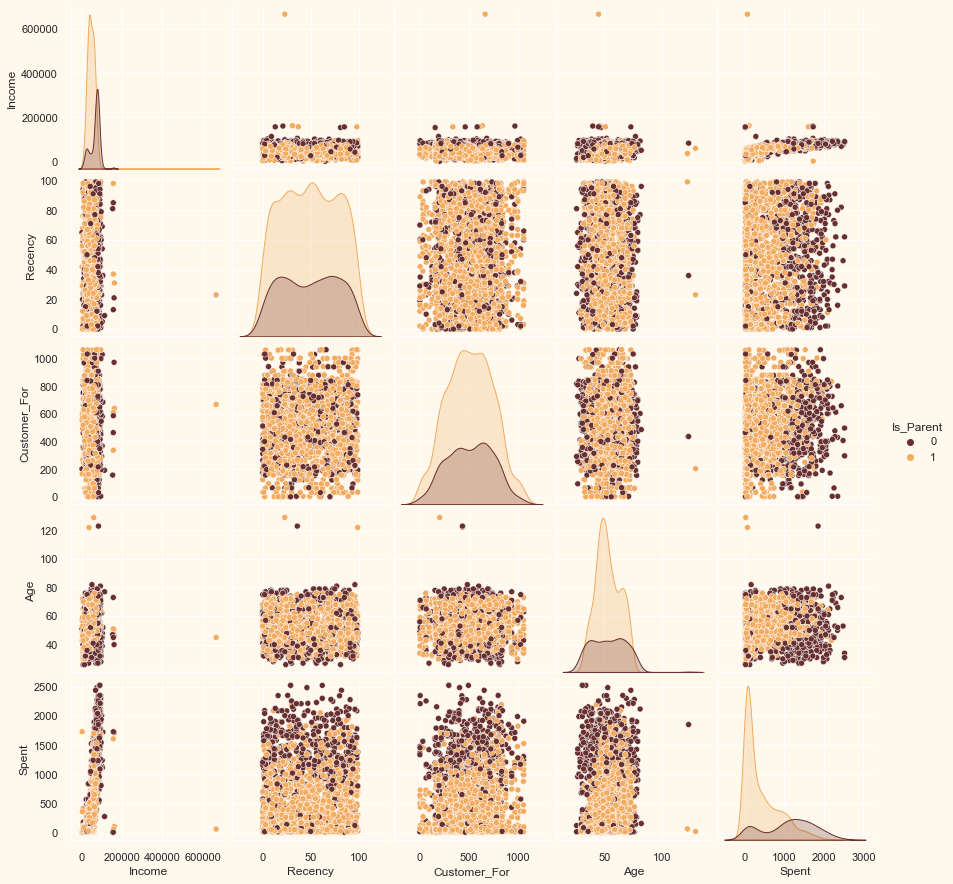

In [63]:
#To plot some selected features 
#Setting up colors prefrences
sns.set(rc={"axes.facecolor":"#FFF9ED","figure.facecolor":"#FFF9ED"})
pallet = ["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"]
cmap = colors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])
#Plotting following features
To_Plot = [ "Income", "Recency", "Customer_For", "Age", "Spent", "Is_Parent"]
print("Reletive Plot Of Some Selected Features: A Data Subset")
plt.figure()
sns.pairplot(data[To_Plot], hue= "Is_Parent",palette= (["#682F2F","#F3AB60"]))
#Taking hue 
plt.show()

In [64]:
#Dropping the outliers by setting a cap on Age and income. 
data = data[(data["Age"]<90)]
data = data[(data["Income"]<600000)]
print("The total number of data-points after removing the outliers are:", len(data))

The total number of data-points after removing the outliers are: 2212


<AxesSubplot:>

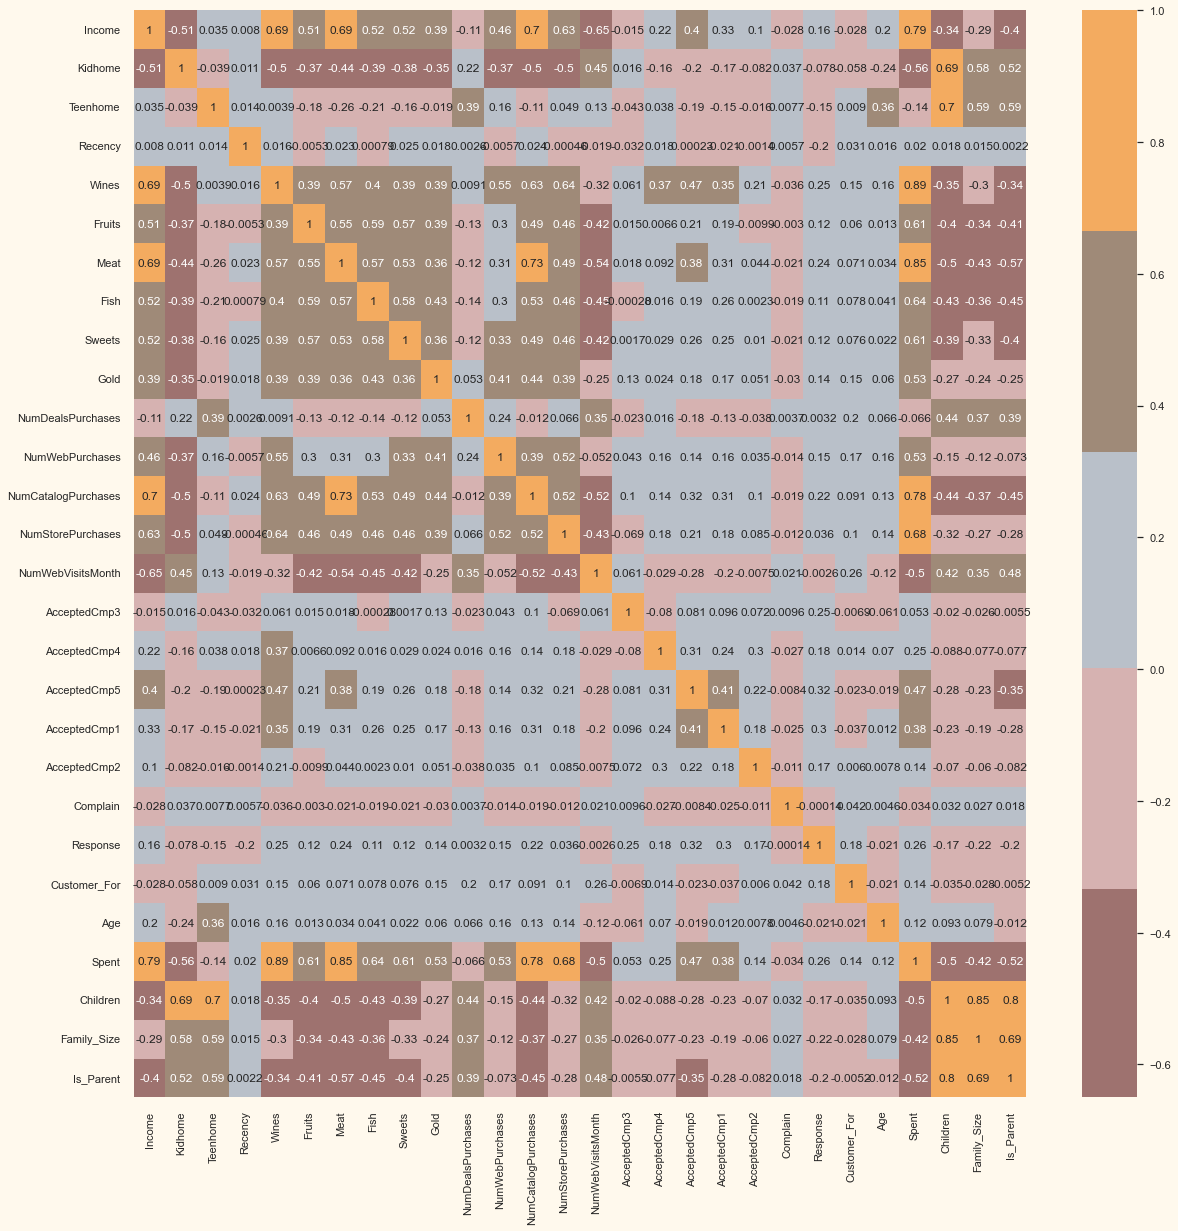

In [65]:
#correlation matrix
corrmat= data.corr()
plt.figure(figsize=(20,20))  
sns.heatmap(corrmat,annot=True, cmap=cmap, center=0)

### Data Preprocessing

#### First, let's convert the categorical values to numerical ones

In [66]:
#Get list of categorical variables
s = (data.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables in the dataset:", object_cols)

Categorical variables in the dataset: ['Education', 'Living_With']


In [67]:
#Label Encoding the object dtypes.
LE=LabelEncoder()
for i in object_cols:
    data[i]=data[[i]].apply(LE.fit_transform)
    
print("All features are now numerical")

All features are now numerical


#### Scaling the features using the standard scaler to decrease the influence of extreme values

In [68]:
#Creating a copy of data
ds = data.copy()
# creating a subset of dataframe by dropping the features on deals accepted and promotions
cols_del = ['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1','AcceptedCmp2', 'Complain', 'Response']
ds = ds.drop(cols_del, axis=1)
#Scaling
scaler = StandardScaler()
scaler.fit(ds)
scaled_ds = pd.DataFrame(scaler.transform(ds),columns= ds.columns )
print("All features are now scaled")

All features are now scaled


In [69]:
#Scaled data to be used for reducing the dimensionality
print("Dataframe to be used for further modelling:")
scaled_ds.head()

Dataframe to be used for further modelling:


,Education,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,...,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Customer_For,Age,Spent,Living_With,Children,Family_Size,Is_Parent
0,-0.893586,0.287105,-0.822754,-0.929699,0.310353,0.977660,1.552041,1.690293,2.453472,1.483713,...,2.503607,-0.555814,0.692181,1.973583,1.018352,1.676245,-1.349603,-1.264598,-1.758359,-1.581139
1,-0.893586,-0.260882,1.040021,0.908097,-0.380813,-0.872618,-0.637461,-0.718230,-0.651004,-0.634019,...,-0.571340,-1.171160,-0.132545,-1.665144,1.274785,-0.963297,-1.349603,1.404572,0.449070,0.632456
2,-0.893586,0.913196,-0.822754,-0.929699,-0.795514,0.357935,0.570540,-0.178542,1.339513,-0.147184,...,-0.229679,1.290224,-0.544908,-0.172664,0.334530,0.280110,0.740959,-1.264598,-0.654644,-1.581139
3,-0.893586,-1.176114,1.040021,-0.929699,-0.795514,-0.872618,-0.561961,-0.655787,-0.504911,-0.585335,...,-0.913000,-0.555814,0.279818,-1.923210,-1.289547,-0.920135,0.740959,0.069987,0.449070,0.632456
4,0.571657,0.294307,1.040021,-0.929699,1.554453,-0.392257,0.419540,-0.218684,0.152508,-0.001133,...,0.111982,0.059532,-0.132545,-0.822130,-1.033114,-0.307562,0.740959,0.069987,0.449070,0.632456


#### Creating a subset dataframe for dimensionality reduction

In [70]:
#Initiating PCA to reduce dimentions aka features to 3
pca = PCA(n_components=3)
pca.fit(scaled_ds)
PCA_ds = pd.DataFrame(pca.transform(scaled_ds), columns=(["col1","col2", "col3"]))
PCA_ds.describe()

,col1,col2,col3
count,2.212000e+03,2.212000e+03,2.212000e+03
mean,-1.447506e-16,-6.073101e-17,6.050515e-17
std,2.878377e+00,1.706839e+00,1.221956e+00
min,-5.969394e+00,-4.312196e+00,-3.530416e+00
25%,-2.538494e+00,-1.328316e+00,-8.290674e-01
50%,-7.804209e-01,-1.581233e-01,-2.269238e-02
75%,2.383290e+00,1.242289e+00,7.998952e-01
max,7.444305e+00,6.142721e+00,6.611222e+00


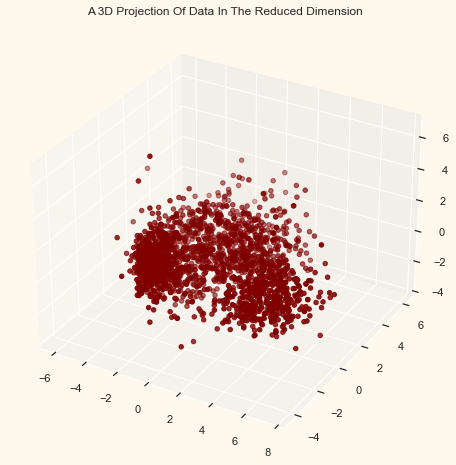

In [71]:
#A 3D Projection Of Data In The Reduced Dimension
x =PCA_ds["col1"]
y =PCA_ds["col2"]
z =PCA_ds["col3"]
#To plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x,y,z, c="maroon", marker="o" )
ax.set_title("A 3D Projection Of Data In The Reduced Dimension")
plt.show()

## Clustering

### 1. K-Means

### Find the "n-clusters"
#### method 1 : gap_statistic You can see the detail and running by (https://github.com/milesgranger/gap_statistic)

#### method 2: Elbow Method(SSE)

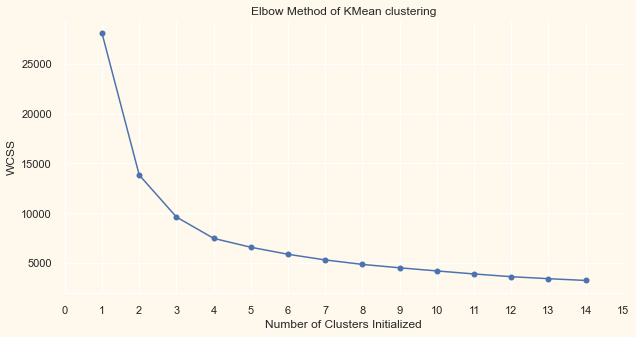

In [72]:
# source https://www.analyticsvidhya.com/blog/2021/01/in-depth-intuition-of-k-means-clustering-algorithm-in-machine-learning/
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
Distance = []  
for k in range(1,15):
    km = KMeans(n_clusters=k)  
    km.fit(PCA_ds)
    #inertia_ return Sum of squared distances of samples to their closest cluster center, weighted by the sample weights if provided.
    Distance.append(km.inertia_)

plt.figure(figsize=(10,5))   
plt.plot(range(1,15),Distance,'o-')
plt.xticks(range(0,16,1)) 
plt.xlabel("Number of Clusters Initialized")
plt.ylabel('WCSS')
plt.title("Elbow Method of KMean clustering")
sns.despine()

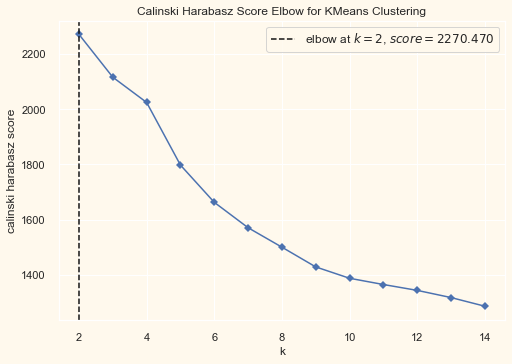

<AxesSubplot:title={'center':'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [73]:
#source https://www.scikit-yb.org/en/latest/api/cluster/elbow.html
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from yellowbrick.cluster import KElbowVisualizer
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(
    model, k=(2,15), metric='calinski_harabasz', timings=False
)
visualizer.fit(PCA_ds)        # Fit the data to the visualizer
visualizer.show()

#### Method 3: Silhouette Coefficient 

find the top point in the plot

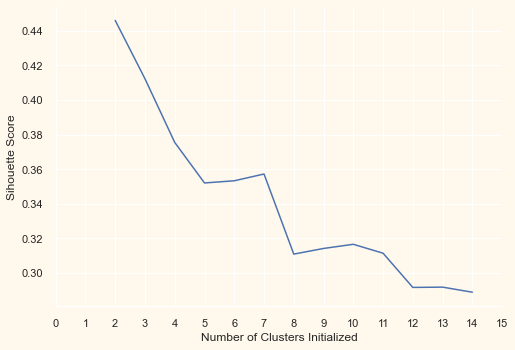

In [74]:
from sklearn import metrics

scores = []
for k in range(2,15):
    labels = KMeans(n_clusters=k).fit(PCA_ds).labels_
    #silhouette_score return Mean Silhouette Coefficient for all samples
    score = metrics.silhouette_score(PCA_ds, labels)
    scores.append(score)

plt.plot(list(range(2,15)),scores)
plt.xticks(range(0,16,1)) 

plt.xlabel("Number of Clusters Initialized")
plt.ylabel("Sihouette Score")
sns.despine()

##### We can see the Calinski Harabasz Elbow Score and the Silhouette Coefficient both show k=2 is the best; however, we observed the score for four is also quite good and more clusters can describe the customer segments more specificly. So, we stick with four as the number of segments.

### K-Mean function

In [87]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters = 4,init="k-means++", n_init=10, max_iter=300, tol=0.0001, verbose=0, random_state=None, copy_x=True, algorithm="auto")
label_kmean = kmeans.fit_predict(PCA_ds)
PCA_ds["Clusters_kmean"] = label_kmean
#Adding the Clusters feature to the orignal dataframe.
data["Clusters_kmean"]= label_kmean

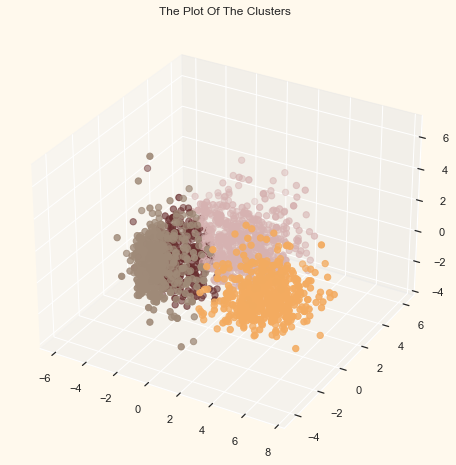

In [94]:
#Plotting the clusters
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, c=PCA_ds["Clusters_kmean"], marker='o', cmap = cmap )
ax.set_title("The Plot Of The Clusters")
plt.show()

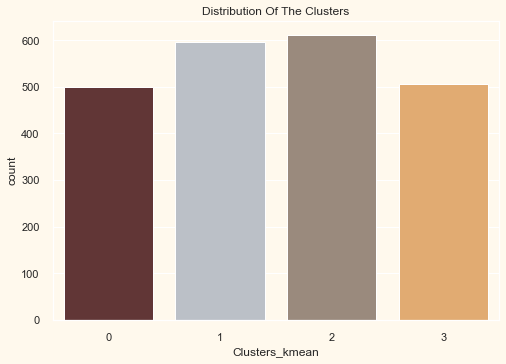

In [95]:
#Plotting countplot of clusters
pl = sns.countplot(x=data["Clusters_kmean"], palette= pal)
pl.set_title("Distribution Of The Clusters")
plt.show()

##### To evaluate the clustering results, we visualize the spent-income pairs as below:

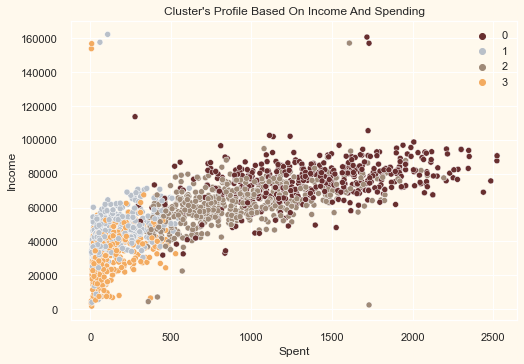

In [79]:
pal = ["#682F2F","#B9C0C9", "#9F8A78","#F3AB60"]
pl = sns.scatterplot(data = data,x=data["Spent"], y=data["Income"],hue=data["Clusters_kmean"], palette= pal)
pl.set_title("Cluster's Profile Based On Income And Spending")
plt.legend()
plt.show()

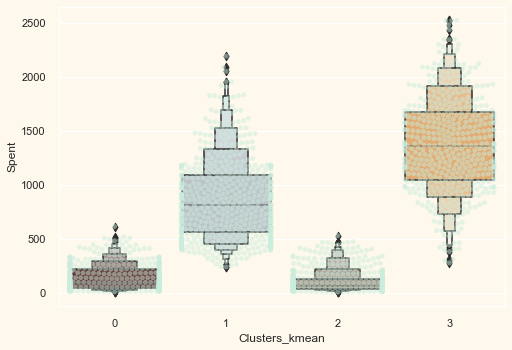

In [96]:
# to plot the spent by clusters
plt.figure()
pl=sns.swarmplot(x=data["Clusters_kmean"], y=data["Spent"], color= "#CBEDDD", alpha=0.5 )
pl=sns.boxenplot(x=data["Clusters_kmean"], y=data["Spent"], palette=pal)
plt.show()

##### Basicly, we can identify four groups:
group 0: high spending & high income

group 1: low spending & average income

group 2: average spending & average income

group 3: low spending & low income

The income and spent are positively related

### 2. Hierachical Clustering

In order to make a comparison, we implement the hierachical cluseting as well. First, let's see the dendrograms as below:

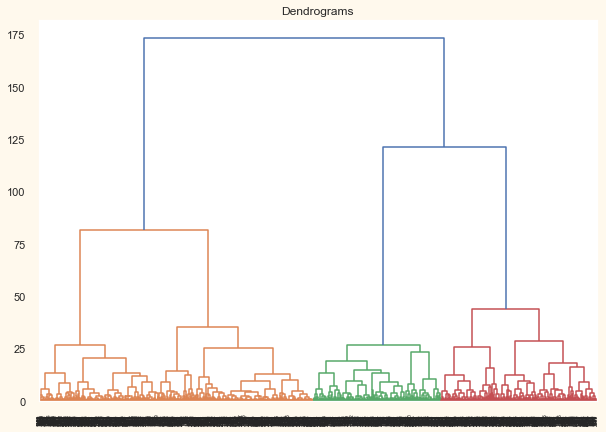

In [82]:
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(PCA_ds, method='ward'))

##### four clusters should be a good choice since the cluster sizes are more evenly distributed

In [83]:
#Initiating the Agglomerative Clustering model 
AC = AgglomerativeClustering(n_clusters=4)
# fit model and predict clusters
yhat_AC = AC.fit_predict(PCA_ds)
PCA_ds["Clusters_hier"] = yhat_AC
#Adding the Clusters feature to the orignal dataframe.
data["Clusters_hier"]= yhat_AC

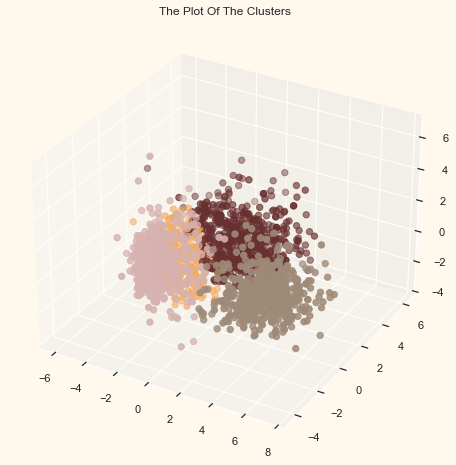

In [84]:
#Plotting the clusters
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, c=PCA_ds["Clusters_hier"], marker='o', cmap = cmap )
ax.set_title("The Plot Of The Clusters")
plt.show()

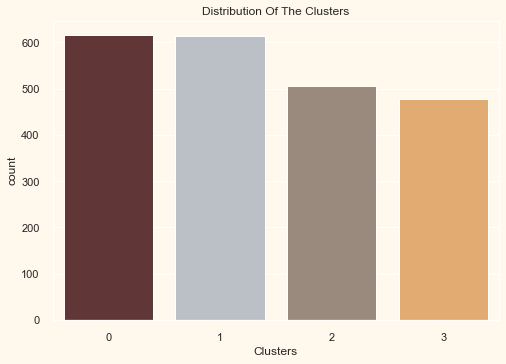

In [85]:
#Plotting countplot of clusters
pl = sns.countplot(x=data["Clusters_hier"], palette= pal)
pl.set_title("Distribution Of The Clusters")
plt.show()

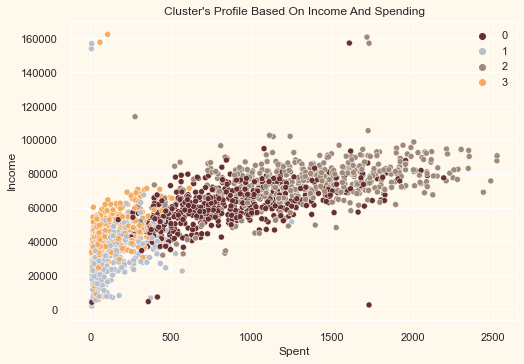

In [86]:
pl = sns.scatterplot(data = data,x=data["Spent"], y=data["Income"],hue=data["Clusters_hier"], palette= pal)
pl.set_title("Cluster's Profile Based On Income And Spending")
plt.legend()
plt.show()

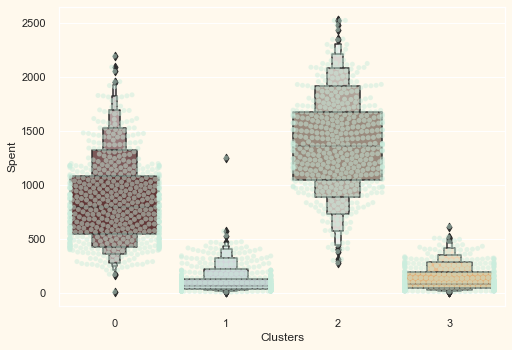

In [89]:
# to plot the spent by clusters
plt.figure()
pl=sns.swarmplot(x=data["Clusters_hier"], y=data["Spent"], color= "#CBEDDD", alpha=0.5 )
pl=sns.boxenplot(x=data["Clusters_hier"], y=data["Spent"], palette=pal)
plt.show()

Similarly, we can observe four clusters:

group 0: average spending & average income

group 1: low spending & low income

group 2: high spending & high income

group 3: low spending & average income

The results are same with the K-mean method; but the hierachical clustering plots show more overlaps than the K-mean method. So in this case, the K-mean method seems better.